In [1]:
# imports
import pandas as pd
import pickle as pkl
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split as tts
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from joblib import load
import warnings
#
from moduleDatabase import DatabaseMethods
from moduleMetrics import MetricsMethods
from moduleUtilities import UtilityMethods
warnings.filterwarnings(action='once')

In [2]:
# class instances
evaluate = MetricsMethods()
ut = UtilityMethods()

In [3]:
# class instantiation
db = DatabaseMethods()

In [4]:
df = db.fetch("SELECT * FROM v9")
df = db.separate_target_class(df, "moca_pre_binary_binned")

In [5]:
X = df[ut.fs['auto_init']]
y = df['target_class']

In [6]:
# discretization
discretizer = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='quantile')

# one hot encoding
ohe = OneHotEncoder(sparse=False)

# column transformer
# https://nbviewer.jupyter.org/github/justmarkham/scikit-learn-tips/blob/master/notebooks/01_column_transformer.ipynb
ct = make_column_transformer(
    (discretizer, ['total_win_gr_points_in_gs']),  # apply OneHotEncoder to Embarked and Sex
#     (ohe, ['marital_status']),              # apply SimpleImputer to Age
    remainder='passthrough')     # include remaining column (Fare) in the output

# scaling
# with open('dataframes/df_std.joblib', 'rb') as f: scaler = load(f)
scaler = StandardScaler()

# oversampling
oversampler = SMOTE(random_state=7)

# dimensionality reduction
# pca_t = None
# with open('fragments/pca_t.joblib', 'rb') as f: pca_t = load(f)
pca_t = PCA(n_components=2)

In [7]:
pipelines = {}

# algorithms
clfs = {
    # optimized for manually selected features
    'LogisticRegression': LogisticRegression(random_state=7, penalty='none', solver='newton-cg'),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=7, criterion='gini', max_depth=7),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=13, random_state=7, criterion='gini', max_depth=5),
    'SVC': SVC(random_state=7, kernel="linear", C=2.5, probability=True, degree=1, gamma='scale'),
    'GaussianNB': GaussianNB(var_smoothing=0.0),
    'MLPClassifier': MLPClassifier(random_state=7, max_iter=200, activation='relu', solver='lbfgs'),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=3, algorithm='auto', weights='uniform')
}

# split
x_train, x_test, y_train, y_test = tts(X, y, test_size=0.3, stratify=y, random_state=7)

#
for (md_id, model) in clfs.items():
    pipeline_temp = Pipeline([
        ('ct', ct), 
        ('scale', scaler), 
        ('oversample', oversampler), 
        ('pca',pca_t), 
        ('clf', model)
        ])
    pipeline_trained = pipeline_temp.fit(x_train, y_train)
    print(model, '\nAccuracy in training:', accuracy_score(y_train, pipeline_trained.predict(x_train)))
    pipelines[md_id] = pipeline_trained

LogisticRegression(penalty='none', random_state=7, solver='newton-cg') 
Accuracy in training: 1.0
DecisionTreeClassifier(max_depth=7, random_state=7) 
Accuracy in training: 1.0
RandomForestClassifier(max_depth=5, n_estimators=13, random_state=7) 
Accuracy in training: 1.0
SVC(C=2.5, degree=1, kernel='linear', probability=True, random_state=7) 
Accuracy in training: 0.9879518072289156
GaussianNB(var_smoothing=0.0) 
Accuracy in training: 0.9759036144578314
MLPClassifier(random_state=7, solver='lbfgs') 
Accuracy in training: 1.0
KNeighborsClassifier(n_neighbors=3) 
Accuracy in training: 0.9759036144578314


Count of label NC (id 2 in Database, 1 in CM) in y_test: 8
Count of label AD-MCI (id 1 in Database, 0 in CM) in y_test: 28 


 LogisticRegression Scores
accuracy : 97.50% Std.: 5.00%
precision : 100.00% Std.: 0.00%
recall : 96.67% Std.: 6.67%
f1 : 98.18% Std.: 3.64%
make_scorer(custom_sensitivity) : 96.60% Std.: 6.80%
make_scorer(custom_specificity) : 100.00% Std.: 0.00%

 DecisionTreeClassifier Scores
accuracy : 88.57% Std.: 10.69%
precision : 93.81% Std.: 7.62%
recall : 92.00% Std.: 16.00%
f1 : 91.64% Std.: 9.14%
make_scorer(custom_sensitivity) : 92.00% Std.: 16.00%
make_scorer(custom_specificity) : 70.00% Std.: 40.00%

 RandomForestClassifier Scores
accuracy : 88.57% Std.: 10.69%
precision : 93.81% Std.: 7.62%
recall : 92.00% Std.: 16.00%
f1 : 91.64% Std.: 9.14%
make_scorer(custom_sensitivity) : 92.00% Std.: 16.00%
make_scorer(custom_specificity) : 70.00% Std.: 40.00%

 SVC Scores
accuracy : 97.50% Std.: 5.00%
precision : 100.00% Std.: 0.00%
recall : 96.67% Std.: 6.67%
f1 : 98.18% S

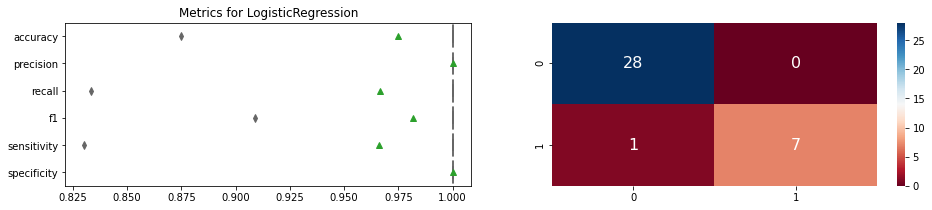

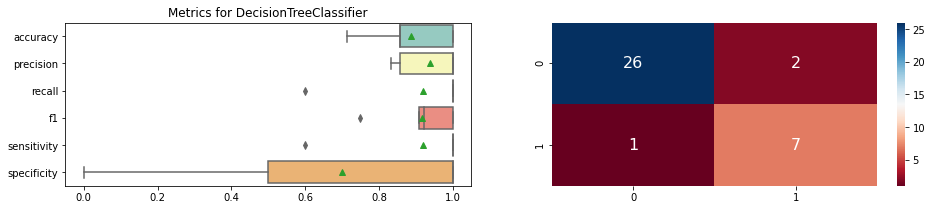

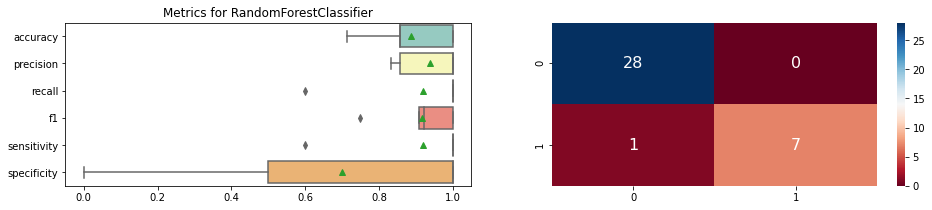

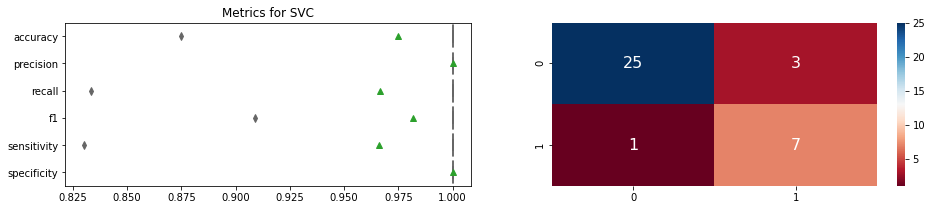

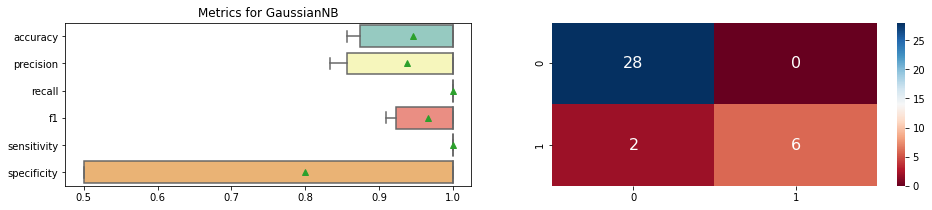

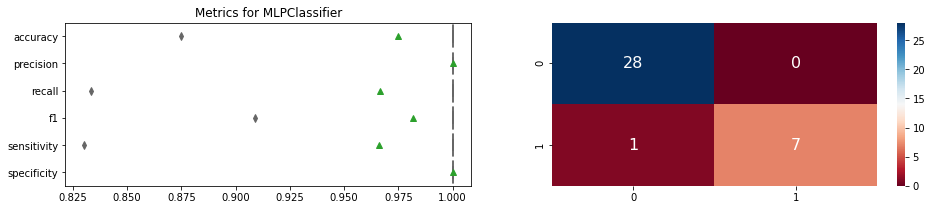

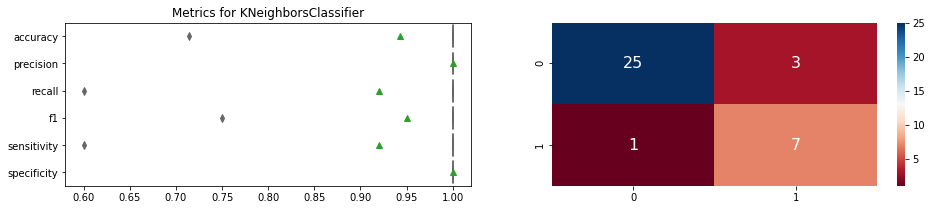

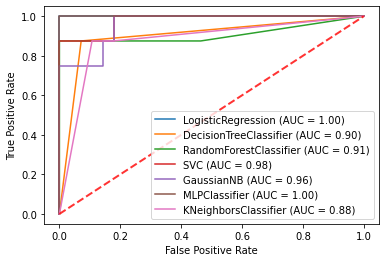

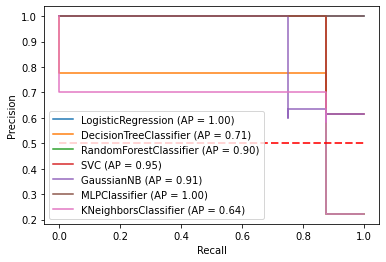

In [8]:
# Evaluate models _for_multiple_production_models
evaluate.generate_metrics(
    pipelines,
    x_test, 
    y_test,
    ['accuracy', 'precision', 'recall', 'f1', 'sensitivity', 'specificity', ],
    cv_num=ut.sd['cv_num'], 
    show_raw_data=True
)

In [9]:
# # save model for service
pathFileName = 'models/model.joblib'
# pkl.dump(pipelines.get('SVC'), open(pathFileName, 'wb'))
# print(type(pipelines.get('SVC')))